In [1]:
from numba import njit
import numpy as np
from lib.utils import create_windows, file_to_data_frame, ExtendedPortfolio
import pandas as pd
import vectorbt as vbt

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Volume USDT', 'Tradecount'], dtype='object')


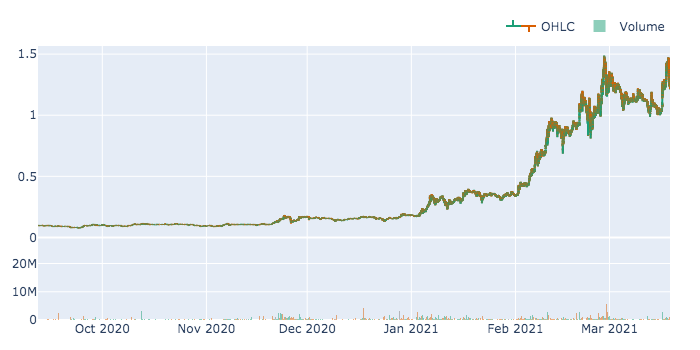

                        Open     High      Low    Close
date                                                   
2020-09-11 20:41:00  0.09609  0.09622  0.09608  0.09622
2020-09-11 20:42:00  0.09625  0.09640  0.09625  0.09634
2020-09-11 20:43:00  0.09631  0.09631  0.09626  0.09626
2020-09-11 20:44:00  0.09624  0.09624  0.09619  0.09623
2020-09-11 20:45:00  0.09623  0.09627  0.09620  0.09627


In [27]:
# leemos el csv
(s_name, ohlcv) = file_to_data_frame(
    "/Users/pilo/development/itba/pf/Binance_Minute_OHLC_CSVs/longs/Binance_ADAUSDT_minute.csv")
# agarramos solo las columnas que necesitamos
cols = ohlcv.columns
print(cols)
ohlcv.get(["Open", "High", "Low", "Close", "Volume"]).vbt.ohlcv.plot().show_png()
ohlc = ohlcv.get(["Open", "High", "Low", "Close"])
print(ohlc.head())

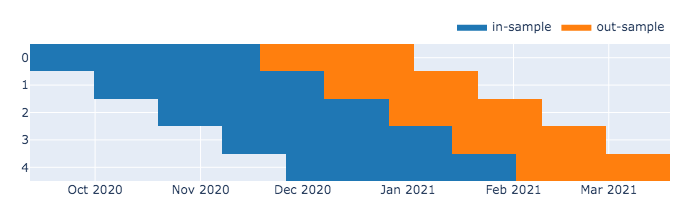

In [28]:
# creamos las ventanas
figure, windows = create_windows(ohlc=ohlc, n=5, window_len=0.6, training_set_len=0.4)
(in_df, in_indexes), (out_df, out_indexes) = windows
figure.show_png()

In [29]:
portfolio_kwargs = dict(
    direction='longonly',
    freq='m'
)


In [32]:
# creamos el indicador
@njit
def apply_func_nb(open: np.ndarray, high: np.ndarray, low: np.ndarray, close: np.ndarray, buy_threshold: float,
                  sell_threshold: float):
    aux = (close - open) / (high - low + 0.001)
    aux = np.where(aux >= buy_threshold, 1, aux)
    aux = np.where(aux <= sell_threshold, -1, aux)
    return aux

AlphaInd = vbt.IndicatorFactory(
    input_names=['open', 'high', 'low', 'close'],
    param_names=['buy_threshold', 'sell_threshold'],
    output_names=['signal']
).from_apply_func(apply_func_nb)
# dir(AlphaInd)

In [33]:
# Corremos con todas las combinaciones
def simulate_all_params(ohlc_windows, params_range):
    # creamos las señales
    open, high, low, close = list(map(lambda tu: tu[1], ohlc_windows.groupby(level=1, axis=1)))
    momentum = AlphaInd.run(open=open, high=high, low=low, close=close,
                            buy_threshold=params_range, sell_threshold=params_range,
                            param_product=True,
                            short_name="alpha")
    ones = np.full(momentum.signal.shape, 1)
    entry_signal = momentum.signal_equal(ones, crossover=True)
    exit_signal = momentum.signal_equal(-ones, crossover=True)
    #trade_price = ohlc_windows.xs("Close", level=1, axis=1)
    return ExtendedPortfolio.from_signals(close, entry_signal, exit_signal, **portfolio_kwargs)

In [35]:
# Optimizamos par el in y el out
params_range = np.linspace(0.1, 1, 9, endpoint=False)
in_elr = simulate_all_params(in_df, params_range).expected_log_returns()
out_elr = simulate_all_params(out_df, params_range).expected_log_returns()

In [36]:
def get_best_index(performance, higher_better=True):
    if higher_better:
        return performance[performance.groupby('split_idx').idxmax()].index
    return performance[performance.groupby('split_idx').idxmin()].index

def get_best_params(best_index, level_name):
    return best_index.get_level_values(level_name).to_numpy()

In [37]:
#Buscamos el índice de los mejores resultados del in 
in_best_index = get_best_index(in_elr)
print(in_best_index)

MultiIndex([(0.8,                0.1, 0),
            (0.9, 0.7000000000000001, 1),
            (0.9, 0.7000000000000001, 2),
            (0.9, 0.7000000000000001, 3),
            (0.9, 0.7000000000000001, 4)],
           names=['alpha_buy_threshold', 'alpha_sell_threshold', 'split_idx'])


In [40]:
in_best_buy_thresholds = get_best_params(in_best_index, 'alpha_buy_threshold')
in_best_sell_thresholds = get_best_params(in_best_index, 'alpha_sell_threshold')
in_best_threshold_pairs = np.array(list(zip(in_best_buy_thresholds, -in_best_sell_thresholds)))

print(in_best_threshold_pairs)

[[ 0.8 -0.1]
 [ 0.9 -0.7]
 [ 0.9 -0.7]
 [ 0.9 -0.7]
 [ 0.9 -0.7]]


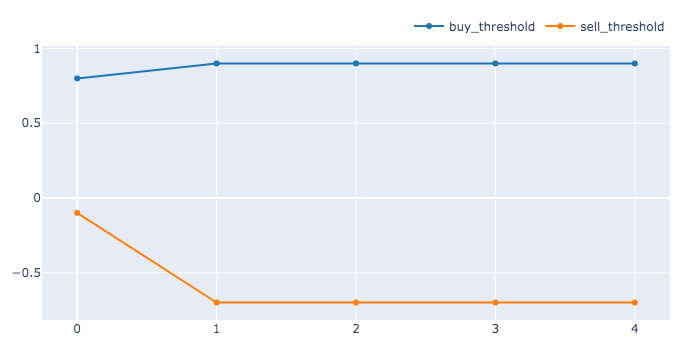

In [41]:
pd.DataFrame(in_best_threshold_pairs, columns=['buy_threshold', 'sell_threshold']).vbt.plot().show_png()

In [42]:
# Corremos el out con los mejores parámetros de in
open, high, low, close = list(map(lambda tu: tu[1], in_df.groupby(level=1, axis=1)))
momentum = AlphaInd.run(open=open, high=high, low=low, close=close,
                        buy_threshold=in_best_buy_thresholds, sell_threshold=in_best_sell_thresholds,
                        short_name="alpha", per_column=True)
ones = np.full(momentum.signal.shape, 1)
entry_signal = momentum.signal_equal(ones, crossover=True)
exit_signal = momentum.signal_equal(-ones, crossover=True)
#trade_price = ohlc_windows.xs("Close", level=1, axis=1)
out_test_elr = ExtendedPortfolio.from_signals(close, entry_signal, exit_signal, **portfolio_kwargs).expected_log_returns()
print(out_test_elr)

alpha_buy_threshold  alpha_sell_threshold  split_idx
0.8                  0.1                   0            0.000000e+00
0.9                  0.7                   1           -5.269119e-07
                                           2           -5.269119e-07
                                           3           -5.269119e-07
                                           4           -5.269119e-07
Name: expected_log_returns, dtype: float64


In [43]:
# simulamos Buy&Hold de cada in y out window y tomamos el expected log returns (elr)
close_columns = list(filter(lambda col: "Close" in col[1], in_df.columns))
in_hold_elr = ExtendedPortfolio.from_holding(in_df[close_columns], **portfolio_kwargs).expected_log_returns()
out_hold_elr = ExtendedPortfolio.from_holding(out_df[close_columns], **portfolio_kwargs).expected_log_returns()
print(in_hold_elr, out_hold_elr)

split_idx       
0          Close    0.000001
1          Close    0.000005
2          Close    0.000004
3          Close    0.000011
4          Close    0.000009
Name: expected_log_returns, dtype: float64 split_idx       
0          Close    0.000008
1          Close    0.000012
2          Close    0.000023
3          Close    0.000020
4          Close    0.000018
Name: expected_log_returns, dtype: float64


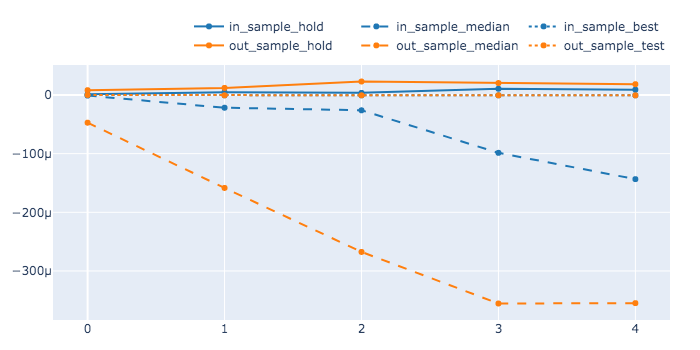

In [44]:
cv_results_df = pd.DataFrame({
    'in_sample_hold': in_hold_elr.values,
    'in_sample_median': in_elr.groupby('split_idx').median().values,
    'in_sample_best': in_elr[in_best_index].values,
    'out_sample_hold': out_hold_elr.values,
    'out_sample_median': out_elr.groupby('split_idx').median().values,
    'out_sample_test': out_test_elr.values
})

cv_results_df.vbt.plot(
    trace_kwargs=[
        dict(line_color=vbt.settings.color_schema['blue']),
        dict(line_color=vbt.settings.color_schema['blue'], line_dash='dash'),
        dict(line_color=vbt.settings.color_schema['blue'], line_dash='dot'),
        dict(line_color=vbt.settings.color_schema['orange']),
        dict(line_color=vbt.settings.color_schema['orange'], line_dash='dash'),
        dict(line_color=vbt.settings.color_schema['orange'], line_dash='dot')
    ]
).show_png()
